# Convolutional Neural Network for MNIST Data

First the relevant modules are imported

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Next, the data for training and testing is loaded and stored in the x and y variables for images and labels. The data comes from a dataset called MNIST which contains images of handwritten digits from 0-9. The loading process can be done using a tensorflow command once the MNIST dataset has been downloaded to a PC: 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
print("Number of training images: {}".format(len(x_train)))
print("Number of testing images: {}".format(len(x_test)))

Number of training images: 60000
Number of testing images: 10000


The images are loaded in the form of 28 x 28 arrays with values of 0-256, which can be displayed as pixels

Image Class: 9


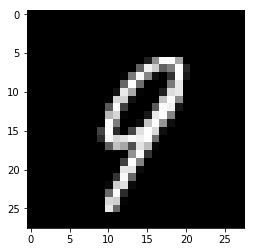

In [3]:
plt.imshow(x_train[22], cmap='gray')
print("Image Class: {}".format(y_train[22]))

The label for each image is in the form of an integer and needs to be 'one hot encoded', where it is turned into an array of nine 0s and one 1 with the position of the 1 within the array denoting the label. For instance 9 would become [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 1 ]. This is because the integers are really a categorical form of data, so it is more appropriate to predict the output in this way rather than a single floating point number between 0 and 9. 

In [4]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)

y_train_one_hot = one_hot_encoder.fit_transform(y_train)

/home/will/yes/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Tensorflow placeholder tensors are created, which are empty tensors with dimensions ready to receive tensors. One receives batches of input images, one their corresponding labels, and the other the learning rate of the CNN. This is the most useful way of including changeable tensors in a Tensorflow program. The None dimension is included so that different sizes of image batches can be fed into the network in one go.

In [5]:
def build_inputs():

    input_tensor = tf.placeholder(tf.float32, (None, 28, 28, 1))
    output_labels = tf.placeholder(tf.float32, (None, 10))
    learning_rate = tf.placeholder(tf.float32)
    
    return (input_tensor, output_labels, learning_rate)

Functions are written separately to build the structure of the network, calculate the loss function at the output, and define the optimizer algorithm. This architecture was chosen arbitrarily and will need refining for a more complex data set, although it does use a general rule of decreasing the height and width of layers from input to output while increasing the depth. The filters in each layer have dimensions 5 x 5, and they are moved over the previous layer with a stride length of 2. The number of filters increases from 32 in the first layer to 64 in the next and then 128. Relu activation functions and batch normalization are used on the outputs of individual layers to allow the network to generalize to different data better and improve training. The last convolutional layer is flattened and connected to a dense fully connected layer with 10 output nodes for the 10 categories.

In [6]:
def build_cnn(input_tensor, reuse=None):
    
    with tf.variable_scope('network', reuse=reuse):
    
        # Tensor size: 28x28
        input_layer = tf.layers.conv2d(input_tensor, 32, 5, 2, padding='same')
        input_layer = tf.nn.relu(input_layer)
    
        # Tensor size: 14x14
        hidden_layer_1 = tf.layers.conv2d(input_layer, 64, 5, 2, padding='same')
        hidden_layer_1 = tf.layers.batch_normalization(hidden_layer_1, training=True)
        hidden_layer_1 = tf.nn.relu(hidden_layer_1)
    
        # Tensor size: 7x7
        hidden_layer_2 = tf.layers.conv2d(hidden_layer_1, 128, 5, 2, padding='same')
        hidden_layer_2 = tf.layers.batch_normalization(hidden_layer_2, training=True)
        hidden_layer_2 = tf.nn.relu(hidden_layer_2)
    
        # Tensor size: 4x4
        flat_layer = tf.reshape(hidden_layer_2, (-1, 4*4*128))
    
        output_layer = tf.layers.dense(flat_layer, 10)
        logits = output_layer
        output = tf.sigmoid(logits)
        
    return logits, output
    

The loss function uses cross entropy loss after taking sigmoid values of the logits to return them as probabilities between 0 and 1.

In [7]:
def build_loss(logits, labels):
    
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return loss
    

The optimizer function uses an Adam algorithm for backpropagation. The optimizer is preceded by a control dependencies command in order to allow the batch normalization process to update population statistics on each iteration.

In [8]:
def build_optimizer(loss, learning_rate):
    
    train_vars = tf.trainable_variables()
    params = [var for var in train_vars if var.name.startswith('network')]
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    upd = [op for op in ops if op.name.startswith('network')]
    
    with tf.control_dependencies(upd):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss=loss, var_list=params)
    
    return optimizer

The train function calls the each of the previous functions. During each batch iteration, batches of images and labels are fed into the respective placeholder tensors inside the sess.run method. At the end of the training process all of the trained weights within the network are saved.

In [9]:
def train(input_features, input_labels, epoch_count, batch_size, learn_rate):
    
    input_tensor, output_labels, learning_rate = build_inputs()
    logits, output = build_cnn(input_tensor)
    loss = build_loss(logits, output_labels)
    opt = build_optimizer(loss, learn_rate)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        steps = 0
        
        for current_epoch in range(epoch_count):
            
            for current_batch in range(int(len(input_features)/batch_size)):
                
                batch_images = input_features[current_batch * batch_size : current_batch * batch_size + batch_size, :, :]
                batch_images = np.reshape(batch_images, (batch_size, 28, 28, 1))
                batch_labels = input_labels[current_batch * batch_size : current_batch * batch_size + batch_size, :]
                
                steps += 1
                
                _ = sess.run(opt, feed_dict={input_tensor: batch_images, output_labels: batch_labels, learning_rate: learn_rate})
            
                if steps % 100 == 0:
                    current_loss = loss.eval({input_tensor: batch_images, output_labels: batch_labels})
                    print("Current epoch: {}/{}".format(current_epoch + 1, epoch_count))
                    print("Current loss: {}".format(current_loss))
        
        saver.save(sess, "/tmp/model.ckpt")           

In [10]:
epoch_count = 1
batch_size = 32
learning_rate = 0.0001

train_graph = tf.Graph()

with train_graph.as_default():
    train(x_train, y_train_one_hot, epoch_count, batch_size, learning_rate)

Current epoch: 1/1
Current loss: 0.08731301873922348
Current epoch: 1/1
Current loss: 0.04341135546565056
Current epoch: 1/1
Current loss: 0.06348304450511932
Current epoch: 1/1
Current loss: 0.061525214463472366
Current epoch: 1/1
Current loss: 0.04595217853784561
Current epoch: 1/1
Current loss: 0.030772468075156212
Current epoch: 1/1
Current loss: 0.013633126392960548
Current epoch: 1/1
Current loss: 0.017124151811003685
Current epoch: 1/1
Current loss: 0.04435595124959946
Current epoch: 1/1
Current loss: 0.016151878982782364
Current epoch: 1/1
Current loss: 0.013212062418460846
Current epoch: 1/1
Current loss: 0.047010842710733414
Current epoch: 1/1
Current loss: 0.014372485689818859
Current epoch: 1/1
Current loss: 0.007781213615089655
Current epoch: 1/1
Current loss: 0.006052855867892504
Current epoch: 1/1
Current loss: 0.01439860463142395
Current epoch: 1/1
Current loss: 0.012702465057373047
Current epoch: 1/1
Current loss: 0.006778703071177006


The following function loads the trained weights from file, feeds a test image into the network and classifies it.

In [14]:
def classify(input_data):
    
    input_tensor, output_labels, learning_rate = build_inputs()
    
    saver = tf.train.Saver()
    with tf.Session(graph=train_graph) as sess:
        
        saver.restore(sess, "/tmp/model.ckpt")
        
        logits, output = build_cnn(input_tensor, reuse=True)
        test_image = np.reshape(input_data, (1, 28, 28, 1))
        current_output = output.eval({input_tensor:test_image})
    
        plt.imshow(input_data, cmap='gray')
        print("Predicted Image Class: {}".format(np.argmax(current_output)))  
        

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Predicted Image Class: 9


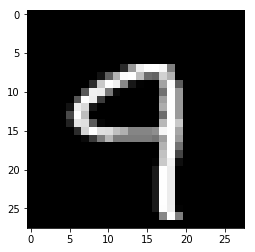

In [41]:
# Enter an integer between 1 and 10000 corresponding to the image in the testing set to be classified
integer = 3492


data_point_index = integer - 1
input_data = x_test[data_point_index]

with train_graph.as_default():
    classify(input_data)
        

The following function calculates the accuracy of the model

In [46]:
def model_accuracy(x_test, y_test):
    
    input_tensor, output_labels, learning_rate = build_inputs()
    
    saver = tf.train.Saver()
    with tf.Session(graph=train_graph) as sess:
        
        saver.restore(sess, "/tmp/model.ckpt")
        
        logits, output = build_cnn(input_tensor, reuse=True)

        correct = 0

        for test_image, test_label in zip(x_test, y_test):
            input_data = np.reshape(test_image, (1, 28, 28, 1))
            current_output = output.eval({input_tensor:input_data})
            class_ = np.argmax(current_output)   
            if class_ == test_label:
                correct += 1
        
        accuracy = correct / len(x_test)
        print("Model accuracy: {}".format(accuracy))
    

In [47]:
# Find the accuracy of this particular model 
with train_graph.as_default():
    model_accuracy(x_test, y_test)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Model accuracy: 0.9759
